https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

I am gonna design the model like the one post in this web-site, adding our features into the RNN and LSTM model.

Characteristic of the model:
1. Based in normal price

# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import matplotlib.pyplot as plt

2021-08-26 00:51:48.017370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 00:51:48.017420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_gemini = pd.read_csv("../data/BTCUSD_4hours.csv")

In [3]:
data_gemini = data_gemini.drop(columns="Unnamed: 0").set_index("date")

In [4]:
data_gemini.shape

(20840, 9)

# Functions and Pipeline

In [5]:
def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.close.ewm(span=t).mean()
    return data

In [6]:
add_ema(data_gemini)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55
date,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,4.390000,4.390000,4.390000,4.390000,4.390000,4.390000
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,4.456806,4.454038,4.454750,4.452900,4.453480,4.452788
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,4.504888,4.499295,4.500741,4.496972,4.498158,4.496743
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915,4.610670,4.594541,4.598680,4.587942,4.591302,4.587294
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438,4.716450,4.688569,4.695756,4.677076,4.682932,4.675945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,47850.404251,48154.042634,46998.714365,47528.909981,46840.328747
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,47905.306220,48195.712939,47061.179717,47589.634030,46902.873464
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,47972.333074,48254.232540,47129.767522,47659.378871,46970.991153


In [7]:
def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



In [8]:
rsi = computeRSI(data_gemini)

In [9]:
def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

In [10]:
stoch_rsi(rsi)

(                          open       high        low      close     volume  \
 date                                                                         
 2011-12-31 16:00:00        NaN        NaN        NaN        NaN        NaN   
 2012-01-01 04:00:00        NaN        NaN        NaN        NaN        NaN   
 2012-01-01 16:00:00        NaN        NaN        NaN        NaN        NaN   
 2012-01-01 20:00:00        NaN        NaN        NaN        NaN        NaN   
 2012-01-02 20:00:00        NaN        NaN        NaN        NaN        NaN   
 ...                        ...        ...        ...        ...        ...   
 2021-08-22 12:00:00  35.005390  34.479767  35.897418  34.998652  16.325185   
 2021-08-22 16:00:00  18.222981  18.007879  18.629785  18.179354  19.001155   
 2021-08-22 20:00:00   4.737093   4.891657   4.703528   4.725876  26.991820   
 2021-08-23 00:00:00  26.473348  26.634274  26.517292  26.555930  45.622606   
 2021-08-23 04:00:00  55.064877  55.163461  55.17912

In [11]:
def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

In [12]:
add_stoch_rsi(data_gemini)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D
date,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,4.390000,4.390000,4.390000,4.390000,4.390000,4.390000,NaN,NaN,NaN
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,4.456806,4.454038,4.454750,4.452900,4.453480,4.452788,NaN,NaN,NaN
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,4.504888,4.499295,4.500741,4.496972,4.498158,4.496743,NaN,NaN,NaN
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915,4.610670,4.594541,4.598680,4.587942,4.591302,4.587294,NaN,NaN,NaN
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438,4.716450,4.688569,4.695756,4.677076,4.682932,4.675945,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,47850.404251,48154.042634,46998.714365,47528.909981,46840.328747,61.965840,34.998652,49.144985
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,47905.306220,48195.712939,47061.179717,47589.634030,46902.873464,59.340648,18.179354,35.095575
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,47972.333074,48254.232540,47129.767522,47659.378871,46970.991153,61.496021,4.725876,19.301294


In [13]:
def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

In [14]:
prices = data_gemini["close"]

In [15]:
get_bollinger_bands(prices, rate=20)

(date
 2011-12-31 08:00:00             NaN
 2011-12-31 16:00:00             NaN
 2012-01-01 04:00:00             NaN
 2012-01-01 16:00:00             NaN
 2012-01-01 20:00:00             NaN
                            ...     
 2021-08-22 12:00:00    47966.601915
 2021-08-22 16:00:00    48165.535906
 2021-08-22 20:00:00    48355.680231
 2021-08-23 00:00:00    48541.008883
 2021-08-23 04:00:00    48725.687139
 Name: close, Length: 20840, dtype: float64,
 date
 2011-12-31 08:00:00             NaN
 2011-12-31 16:00:00             NaN
 2012-01-01 04:00:00             NaN
 2012-01-01 16:00:00             NaN
 2012-01-01 20:00:00             NaN
                            ...     
 2021-08-22 12:00:00    50912.659422
 2021-08-22 16:00:00    50660.931862
 2021-08-22 20:00:00    50371.206423
 2021-08-23 00:00:00    50344.600752
 2021-08-23 04:00:00    50439.681569
 Name: close, Length: 20840, dtype: float64,
 date
 2011-12-31 08:00:00             NaN
 2011-12-31 16:00:00             NaN
 201

In [16]:
def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

In [17]:
add_bollinger(data_gemini,prices)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down
date,,,,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,4.390000,...,4.390000,4.390000,4.390000,4.390000,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,4.456806,...,4.454750,4.452900,4.453480,4.452788,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,4.504888,...,4.500741,4.496972,4.498158,4.496743,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915,4.610670,...,4.598680,4.587942,4.591302,4.587294,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438,4.716450,...,4.695756,4.677076,4.682932,4.675945,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,...,48154.042634,46998.714365,47528.909981,46840.328747,61.965840,34.998652,49.144985,47966.601915,50912.659422,45020.544407
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,...,48195.712939,47061.179717,47589.634030,46902.873464,59.340648,18.179354,35.095575,48165.535906,50660.931862,45670.139951
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,...,48254.232540,47129.767522,47659.378871,46970.991153,61.496021,4.725876,19.301294,48355.680231,50371.206423,46340.154040


In [18]:
def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

In [19]:
add_vol_roc(data_gemini)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,4.390000,...,4.390000,4.390000,4.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,4.456806,...,4.452900,4.453480,4.452788,NaN,NaN,NaN,NaN,NaN,NaN,68.407580
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,4.504888,...,4.496972,4.498158,4.496743,NaN,NaN,NaN,NaN,NaN,NaN,-0.952500
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915,4.610670,...,4.587942,4.591302,4.587294,NaN,NaN,NaN,NaN,NaN,NaN,5.657790
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438,4.716450,...,4.677076,4.682932,4.675945,NaN,NaN,NaN,NaN,NaN,NaN,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,...,46998.714365,47528.909981,46840.328747,61.965840,34.998652,49.144985,47966.601915,50912.659422,45020.544407,2.306553
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,...,47061.179717,47589.634030,46902.873464,59.340648,18.179354,35.095575,48165.535906,50660.931862,45670.139951,-0.727108
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,...,47129.767522,47659.378871,46970.991153,61.496021,4.725876,19.301294,48355.680231,50371.206423,46340.154040,0.307177


In [20]:
data_gemini = data_gemini.dropna()

In [21]:
data_gemini.shape[0]

20809

# Premodeling steps

### Temporal Train-Test Split

In [22]:
train_percentage = 80

In [23]:
train_len = int(len(data_gemini) * train_percentage/100)
train_len

16647

In [24]:
data_train = data_gemini[:train_len]
data_test = data_gemini[train_len:]

In [25]:
print(data_train.shape)
print(data_test.shape)

(16647, 22)
(4162, 22)


### scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

data_train_scaled = minmax_scaler.fit_transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

## Basic Model

### create x and y array

In [27]:
data_train.shape[0]

16647

In [28]:
window_size = 72 #because we want to base our prediction on 3 weeks (72*4 hours)
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [29]:
len(data_train_subsequences)

16575

In [30]:
len(fake_y_train)

16575

In [31]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,5:9]

In [32]:
print(X_train.shape)
print(y_train.shape)

(16575, 72, 22)
(16575, 4)


### Initialize a model & set layers

In [33]:
# Initialize a model, add a masking layer,LSTM,Dense Layers 
model = Sequential()
#model.add(normalizer)
#model.add(layers.Masking(mask_value=-1))
model.add(layers.LSTM(units=50, activation='relu',input_shape = (X_train.shape[1],22), return_sequences = True)) # first run 64 units
model.add(Dropout(0.2)) 
model.add(layers.LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(layers.LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(layers.LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(layers.Dense(units =4))
#model.add(layers.Dense(4, activation="relu"))

model.summary()


2021-08-26 00:51:51.206856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-26 00:51:51.206923: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-26 00:51:51.206944: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-QQH7A32G): /proc/driver/nvidia/version does not exist
2021-08-26 00:51:51.207220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 50)            14600     
_________________________________________________________________
dropout (Dropout)            (None, 72, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 72, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 72, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 72, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

### Compile Model 


In [34]:
# later add: es = EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics="mae")
#model.compile(optimizer='rmsprop', loss="mse", metrics="mae")

### Fit Model

In [35]:
history= model.fit(X_train, y_train, epochs = 20, batch_size =50, validation_split=0.1)
#model.fit(X_train,y_train,epochs=10, batch_size=64, validation_split=0.3)

2021-08-26 00:51:51.762883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
299/299 [==============================] - 73s 232ms/step - loss: 0.4067 - mae: 0.1261 - val_loss: 0.0100 - val_mae: 0.0992
Epoch 2/20
299/299 [==============================] - 65s 216ms/step - loss: 0.0086 - mae: 0.0690 - val_loss: 0.0131 - val_mae: 0.1141
Epoch 3/20
299/299 [==============================] - 64s 214ms/step - loss: 0.0060 - mae: 0.0575 - val_loss: 0.0111 - val_mae: 0.1047
Epoch 4/20
299/299 [==============================] - 61s 205ms/step - loss: 0.0047 - mae: 0.0510 - val_loss: 0.0169 - val_mae: 0.1293
Epoch 5/20
299/299 [==============================] - 62s 209ms/step - loss: 0.0041 - mae: 0.0472 - val_loss: 0.0101 - val_mae: 0.0995
Epoch 6/20
299/299 [==============================] - 60s 200ms/step - loss: 0.0034 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0747
Epoch 7/20
299/299 [==============================] - 58s 193ms/step - loss: 0.0030 - mae: 0.0400 - val_loss: 0.0077 - val_mae: 0.0868
Epoch 8/20
299/299 [==============================] - 6

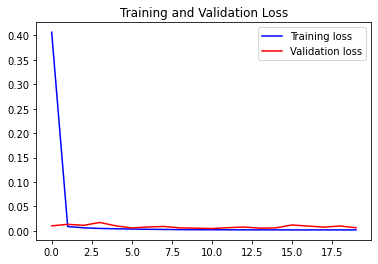

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## create X_test & y_test

In [37]:
#with the same window_size & horizon as the train data
window_size = 72
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [38]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,5:9]

In [39]:
print(X_test.shape)
print(y_test.shape)

(4090, 72, 22)
(4090, 4)


In [40]:
y_test

array([[0.89919302, 0.89921484, 0.89926036, 0.89919776],
       [0.89920248, 0.89922101, 0.89928913, 0.89921206],
       [0.89885214, 0.89885762, 0.89893084, 0.89885577],
       ...,
       [1.10874385, 1.10871904, 1.10885782, 1.10875337],
       [1.11108174, 1.11107007, 1.11118873, 1.11109402],
       [1.11226691, 1.11223155, 1.11238067, 1.11226782]])

### Predict 

In [41]:
#min1 = minmax_scaler.data_min_[5:9]

In [42]:
#range1 = minmax_scaler.data_range_[5:9]

In [43]:
y_pred = model.predict(X_test) 
y_pred, y_test
#predictions = model.predict(X_test)

(array([[0.8184514 , 0.8169689 , 0.8161316 , 0.8174907 ],
        [0.8184758 , 0.81698334, 0.81613195, 0.81744564],
        [0.81837523, 0.81688094, 0.8160044 , 0.81725454],
        ...,
        [1.1568356 , 1.1630517 , 1.1673998 , 1.1599622 ],
        [1.1582937 , 1.1644018 , 1.1689451 , 1.1611881 ],
        [1.1599098 , 1.1659443 , 1.1707498 , 1.1628151 ]], dtype=float32),
 array([[0.89919302, 0.89921484, 0.89926036, 0.89919776],
        [0.89920248, 0.89922101, 0.89928913, 0.89921206],
        [0.89885214, 0.89885762, 0.89893084, 0.89885577],
        ...,
        [1.10874385, 1.10871904, 1.10885782, 1.10875337],
        [1.11108174, 1.11107007, 1.11118873, 1.11109402],
        [1.11226691, 1.11223155, 1.11238067, 1.11226782]]))

In [44]:
#y_pred = np.exp((predictions * range1 + min1))

In [45]:
minmax_scaler.scale_

array([5.12932739e-05, 5.12664369e-05, 5.13530416e-05, 5.12946303e-05,
       1.38447854e-03, 1.18528098e-01, 1.18520736e-01, 1.18544473e-01,
       1.18528477e-01, 5.33232173e-05, 5.45493145e-05, 5.39488813e-05,
       5.72039779e-05, 5.54098690e-05, 5.77893792e-05, 1.07522127e-02,
       1.00000000e-02, 1.00000000e-02, 5.31857171e-05, 4.97793971e-05,
       5.54538432e-05, 1.32132188e-03])

In [46]:
#y_test_unscaled = np.exp((y_test * range1 + min1))

In [47]:
#len(y_pred)

In [48]:
#len(y_test_unscaled)

In [49]:
#y_test_unscaled

In [50]:
#y_pred.shape

In [51]:
#np.mean(np.abs(y_test_unscaled - y_pred))

In [52]:
scale = 1/minmax_scaler.scale_[0] #resivar esto

In [53]:
y_test = y_test*scale 
y_pred = y_pred*scale

In [54]:
y_pred

array([[15956.312 , 15927.409 , 15911.085 , 15937.581 ],
       [15956.786 , 15927.69  , 15911.092 , 15936.703 ],
       [15954.826 , 15925.694 , 15908.6045, 15932.978 ],
       ...,
       [22553.36  , 22674.547 , 22759.316 , 22614.314 ],
       [22581.787 , 22700.867 , 22789.443 , 22638.215 ],
       [22613.295 , 22730.941 , 22824.627 , 22669.934 ]], dtype=float32)

In [55]:
y_test

array([[17530.4274242 , 17530.85293421, 17531.74038175, 17530.519894  ],
       [17530.61202074, 17530.97321113, 17532.30133631, 17530.79868027],
       [17523.78173996, 17523.888579  , 17525.31612139, 17523.85249422],
       ...,
       [21615.77473237, 21615.29088645, 21617.99653628, 21615.96032573],
       [21661.35347062, 21661.1260693 , 21663.43941041, 21661.5929596 ],
       [21684.459235  , 21683.77002561, 21686.67719209, 21684.47712238]])

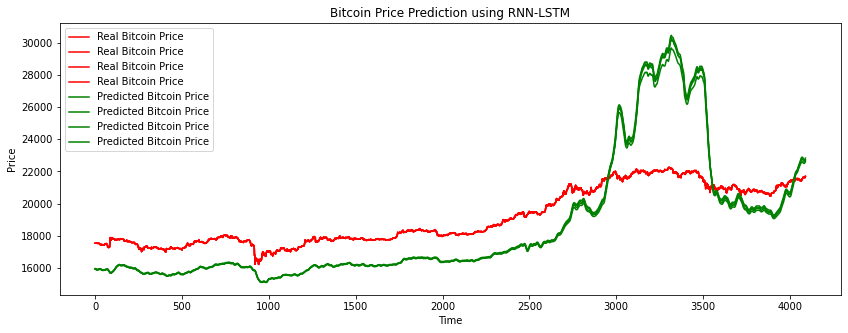

In [56]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()